## Sentinel 1 - Softcon embeddings 

Experimental notebook to gather Sentinel-1 data from Earth Engine and run foundation 
model inference. 

Depends on the external repo: https://github.com/zhu-xlab/softcon and the out-of-repo backbone that is linked on the README page. The local path to the cloned repo is specified in the cell below. 

The softcon model is trained on the SSL4EO-S12 dataset. Dataset statistics for normalization come from: https://arxiv.org/abs/2211.07044, App. 1, p. 8.

In [14]:
from datetime import datetime
import glob
import os
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.transform import Affine
import torch
from torchvision.transforms import transforms
from tqdm import tqdm

import gee
import utils

SOFTCON_PATH = 'softcon/'
sys.path.append(SOFTCON_PATH)
from models.dinov2 import vision_transformer 

SSL4EO_S1_STATS = {  
    'VV': {'mean': -12.59, 'std': 5.26},
    'VH': {'mean': -20.26, 'std': 5.91}
}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Tiling an AOI

In [15]:
region_name = 'tapajos_test_region'
region = gpd.read_file(f'../data/boundaries/{region_name}.geojson').geometry[0].__geo_interface__

tilesize = 1344 # previously 576, around the max size allowed for GEE export for 12-band imagery; 
padding = 24

start_date = datetime(2024, 12, 1)
end_date = datetime(2024, 12, 31)

In [19]:
tiles = utils.create_tiles(region, tilesize=tilesize, padding=padding)
print(f"Created {len(tiles):,} tiles")
print(f'Sample tile data:\n{tiles[0]}')

Created 174 tiles
Sample tile data:
DLTile(key='1344:24:10.0:21:12:-64',
       resolution=10.0,
       tilesize=1344,
       pad=24,
       crs='EPSG:32621',
       bounds=(661040.0, -860400.0, 674960.0, -846480.0),
       bounds_crs='EPSG:32621',
       geometry=<POLYGON ((-5...7.655, -55...>,
       zone=21,
       ti=12,
       tj=-64,
       geotrans=(661040.0, 10.0, 0.0, -846480.0, 0.0, -10.0),
       proj4='+proj=utm +z...s=m +no_defs ',
       wkt='PROJCS["WGS ...SG","32621"]]',
       all_touched=False)


### GEE S1 data download

In [20]:
data_pipeline = gee.GEE_Data_Extractor(
    tiles, 
    start_date, 
    end_date, 
    batch_size=500,
    collection='S1'
    )

In [10]:
data_pipeline.composite.bandNames().getInfo()

['VV', 'VH', 'angle']

In [12]:
pixels = []
for tile in tqdm(tiles):
    pix_array, tile_info = data_pipeline.get_tile_data(tile)
    pix_array = utils.pad_patch(pix_array, tile_info.tilesize)
    pixels.append(pix_array)
    
pixels = np.array(pixels)

100%|█████████████████████████████████████████| 174/174 [57:41<00:00, 19.90s/it]


#### Save S1 data to disk

In [13]:
data_dir = 'S1data'

In [14]:
for img, tile in zip(pixels, tiles):
    
    assert tile.tilesize == img.shape[0]
    assert tile.tilesize == img.shape[1]
    
    img = img.astype('float32')
    
    path = os.path.join(data_dir, f"{region_name}S1_{tile.key}.tif")
    metadata = {
        'count': img.shape[-1],
        'height': tile.tilesize,
        'width': tile.tilesize,
        'crs': tile.crs,
        'transform': Affine(*tile.geotrans),
        'dtype': img.dtype
    }
    
    with rasterio.open(path, 'w', **metadata) as f:
        for band in range(2):
            f.write(img[:, :, band], band + 1)

    print(f"Saved {path}")


Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:12:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:13:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:10:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:11:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:12:-63.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:13:-63.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:10:-63.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:11:-63.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:7:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:8:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:9:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:5:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:6:-64.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:7:-63.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:8:-63.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:9:-63.tif
Saved S1data/tap

Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:-5:-59.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:-4:-59.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:2:-58.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:3:-58.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:4:-58.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:0:-58.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:1:-58.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:2:-57.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:3:-57.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:4:-57.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:2:-56.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:3:-56.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:4:-56.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:0:-57.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:1:-57.tif
Saved S1data/tapajos_test_regionS1_1344:24:10.0:21:0:-56.tif
Saved S1data/tapajos_t

GEE data comes down in shape (tiles, h, w, bands), whereas rasterio, torch, etc. use (tiles, bands, h, w). For consistency we will assume the latter order going forward.

In [15]:
print(pixels.shape)
pixels = np.moveaxis(pixels, -1, 1)
pixels.shape

(174, 1344, 1344, 2)

In [5]:
data_dir = 'S1data'

In [71]:
# Bulk reload data from disk. For inference, tiles are loaded one by one to save RAM. See below.
available_paths = glob.glob(f'{data_dir}/{region_name}*.tif')
paths = []
for tile in tiles[:2]:
    for path in available_paths:
        if tile.key in path:
            paths.append(path)
paths

['S1data/tapajos_test_regionS1_1344:24:10.0:21:12:-64.tif',
 'S1data/tapajos_test_regionS1_1344:24:10.0:21:13:-64.tif']

In [87]:
pixels = []
for path in paths:
    with rasterio.open(path, 'r') as f:
        S1image = f.read()
        profile = f.profile
        pixels.append(S1image)
        
        profile.update({'count': 1, 'dtype': 'uint8'})
        for i, stat in enumerate(SSL4EO_S1_STATS.values()):
            with rasterio.open(path.split('.tif')[0] + f'band{i}.tif', 'w', **profile) as of:
                raster = S1image[i].reshape(1, *S1image[i].shape)
                raster = normalize(raster, stat['mean'], stat['std'])
                of.write(raster)
    
pixels = np.array(pixels)
pixels.shape

(2, 2, 1344, 1344)

In [85]:
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1344, 'height': 1344, 'count': 1, 'crs': CRS.from_epsg(32621), 'transform': Affine(674480.0, 10.0, 0.0,
       -846480.0, 0.0, -10.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}

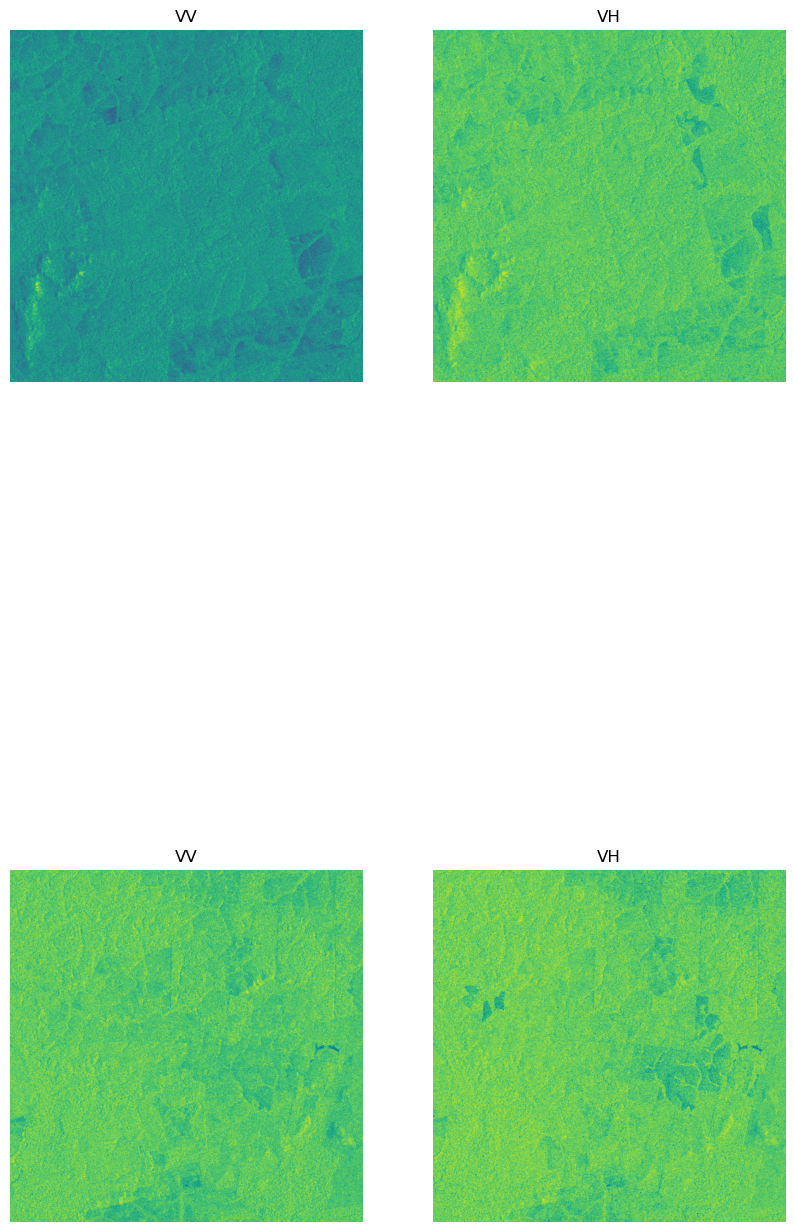

In [73]:
to_view = pixels[:3]

fig, axes = plt.subplots(len(to_view), 2, figsize=(10, 10*len(to_view)))

if axes.ndim == 1:
    axes = axes[np.newaxis, :]  

for row,img in zip(axes, to_view):
    for (ax, band, band_name) in zip(row, img, data_pipeline.bandIds):
        ax.imshow(band)
        ax.set_title(band_name)
        ax.axis("off") 

# plt.savefig(f'{data_dir}/{region_name}_S1to{end_date.date().isoformat()}.png', bbox_inches='tight')

### Inference

In [21]:
# Model

model_chip_size = 224

# For running on Mac Mx chip
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu") 

print(f'Device: {device}')

model = vision_transformer.__dict__['vit_small'](
    img_size=model_chip_size,
    patch_size=14,
    in_chans=2,
    block_chunks=0,
    init_values=1e-5,
    num_register_tokens=0,
)

model_name = 'B2_vits14_softcon.pth'
ckpt_vits14 = torch.load(os.path.join(SOFTCON_PATH, f'pretrained/{model_name}'))
model.load_state_dict(ckpt_vits14)

model.to(device)
model.eval()

Device: mps


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(2, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [41]:
def normalize(band, mean, std):
    """Normalize image data bandwise."""
    min_value = mean - 2 * std
    max_value = mean + 2 * std
    band = (band - min_value) / (max_value - min_value) * 255.0
    band = np.clip(band, 0, 255).astype(np.float32)
    return band

# We split a tile into geographic patches, or chips, with a size determined by experience with object-oriented
# applications. We prefer a chip size of order hundreds of meters rather than kms. After cutting, chips are 
# resized to match the input dimension expected by the model. It works. Why? It's a mystery.

def cut_chips(tile_pixels, tile_info, geo_chip_size=32, stride_frac=2):
    """Split a large geographic tile into patches to be embedded."""
    stride = geo_chip_size // stride_frac
    chips, chip_geoms = utils.chips_from_tile(np.moveaxis(tile_pixels, 0, -1), tile_info, geo_chip_size, stride)
    chips = np.array(chips)
    chips = np.moveaxis(chips, -1, 1)
    chip_geoms.to_crs("EPSG:4326", inplace=True)
    return chips, chip_geoms

In [ ]:
# Inference

geo_chip_size = 32
batch_size = 128 
feature_columns = [f"vit-dino-patch14_{i}" for i in range(features.shape[-1])] 

gdfs = []
for tile in tqdm(tiles[:20]):
    path = os.path.join(data_dir, f"{region_name}S1_{tile.key}.tif")
    with rasterio.open(path, 'r') as f:
        pixels = f.read()
    
    normed = [normalize(band, stats['mean'], stats['std']) for band, stats in zip(pixels, SSL4EO_S1_STATS.values())]
    normed = np.array(normed)
    
    chips, chip_geoms = cut_chips(normed, tile, geo_chip_size=geo_chip_size)
    tensor = torch.from_numpy(chips)
    if geo_chip_size != model_chip_size:
        tensor = transforms.Resize((model_chip_size, model_chip_size), antialias=False).__call__(tensor)

    print(f'Input tensor shape {tensor.shape}')
    tensor = tensor.to(device)
    
    batch_outputs = []
    for i in tqdm(range(0, len(tensor), batch_size)):
        batch = tensor[i : i + batch_size]
        with torch.no_grad():
            batch_output = model(batch)
        batch_outputs.append(batch_output)
    batch_outputs = torch.cat(batch_outputs).cpu().numpy()    
    
    features_df = gpd.pd.DataFrame(batch_outputs, columns=feature_columns)
    gdf = gpd.pd.concat([chip_geoms, features_df], axis=1)
    gdfs.append(gdf)
    
gdf = gpd.pd.concat(gdfs).reset_index(drop=True)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Input tensor shape torch.Size([6889, 2, 224, 224])



  5%|██▏                                         | 1/20 [01:04<20:33, 64.91s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 10%|████▍                                       | 2/20 [02:06<18:49, 62.77s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 15%|██████▌                                     | 3/20 [02:54<15:58, 56.36s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 20%|████████▊                                   | 4/20 [03:48<14:43, 55.19s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 25%|███████████                                 | 5/20 [04:36<13:12, 52.84s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 30%|█████████████▏                              | 6/20 [05:24<11:55, 51.11s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 35%|███████████████▍                            | 7/20 [06:12<10:49, 49.97s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 40%|█████████████████▌                          | 8/20 [07:01<09:55, 49.63s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 45%|███████████████████▊                        | 9/20 [07:50<09:05, 49.57s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 50%|█████████████████████▌                     | 10/20 [08:39<08:13, 49.32s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 55%|███████████████████████▋                   | 11/20 [09:27<07:19, 48.88s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 60%|█████████████████████████▊                 | 12/20 [10:14<06:27, 48.47s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 65%|███████████████████████████▉               | 13/20 [11:02<05:37, 48.18s/it]

Input tensor shape torch.Size([6889, 2, 224, 224])



 43%|██████████████████▎                        | 23/54 [00:19<00:26,  1.16it/s]

In [ ]:
if not os.path.exists(region_name):
    os.mkdir(region_name)

gdf.to_parquet(f"{region_name}/{region_name}_{model_name.split('.pth')[0]}_{geo_chip_size}chip_S1to{end_date.date().isoformat()}-20tiles.parquet", index=False)

#### Optional embedding quantization to save memory

In [66]:
def quantize(embeddings, lower_bound=-5, upper_bound=5):
    clipped = np.clip(embeddings, lower_bound, upper_bound)
    normalized = (clipped - lower_bound) / (upper_bound - lower_bound)
    scaled = normalized * 255
    return scaled.astype(np.uint8)

quantized = quantize(gdf.drop(columns='geometry').to_numpy())
features_df = gpd.pd.DataFrame(quantized, columns=feature_columns)
q_gdf = gpd.pd.concat([gdf['geometry'], features_df], axis=1)
q_gdf.head()

,geometry,vit-dino-patch14_0,vit-dino-patch14_1,vit-dino-patch14_2,vit-dino-patch14_3,vit-dino-patch14_4,vit-dino-patch14_5,vit-dino-patch14_6,vit-dino-patch14_7,vit-dino-patch14_8,...,vit-dino-patch14_374,vit-dino-patch14_375,vit-dino-patch14_376,vit-dino-patch14_377,vit-dino-patch14_378,vit-dino-patch14_379,vit-dino-patch14_380,vit-dino-patch14_381,vit-dino-patch14_382,vit-dino-patch14_383
0,"POLYGON ((-55.54000 -7.65544, -55.53999 -7.658...",87,141,0,183,152,82,82,147,109,...,124,125,37,143,63,146,79,0,122,118
1,"POLYGON ((-55.53999 -7.65694, -55.53998 -7.659...",87,141,0,184,153,80,82,147,109,...,122,124,33,142,62,145,79,0,121,117
2,"POLYGON ((-55.53999 -7.65844, -55.53998 -7.661...",87,141,0,184,153,81,82,147,109,...,122,124,35,142,62,145,79,0,121,117
3,"POLYGON ((-55.53998 -7.65994, -55.53997 -7.662...",86,141,0,183,153,81,82,147,108,...,123,125,37,142,63,146,79,0,122,118
4,"POLYGON ((-55.53998 -7.66143, -55.53997 -7.664...",87,141,0,185,154,80,82,148,109,...,121,124,33,142,61,144,79,0,121,116


In [68]:
# Inspect to ensure sufficient variance after quantization and adjust upper / lower bound accordingly
q_gdf.describe()

,vit-dino-patch14_0,vit-dino-patch14_1,vit-dino-patch14_2,vit-dino-patch14_3,vit-dino-patch14_4,vit-dino-patch14_5,vit-dino-patch14_6,vit-dino-patch14_7,vit-dino-patch14_8,vit-dino-patch14_9,...,vit-dino-patch14_374,vit-dino-patch14_375,vit-dino-patch14_376,vit-dino-patch14_377,vit-dino-patch14_378,vit-dino-patch14_379,vit-dino-patch14_380,vit-dino-patch14_381,vit-dino-patch14_382,vit-dino-patch14_383
count,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,...,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,13778.000000,13778.0,13778.000000,13778.000000
mean,88.581434,141.115692,0.197997,186.357454,156.576354,78.067354,82.517129,147.713964,110.059225,166.298737,...,118.697126,122.655465,26.467557,140.177602,60.131224,142.343954,81.025112,0.0,118.190521,113.446073
std,1.216408,0.568689,1.403701,1.601710,2.576551,1.543201,0.754097,0.698287,0.900979,4.011383,...,2.474301,1.453434,5.212686,1.836703,1.367101,1.913439,1.856531,0.0,1.878715,2.181408
min,81.000000,137.000000,0.000000,176.000000,149.000000,69.000000,69.000000,134.000000,99.000000,146.000000,...,97.000000,116.000000,0.000000,105.000000,57.000000,127.000000,77.000000,0.0,104.000000,105.000000
25%,88.000000,141.000000,0.000000,185.000000,155.000000,77.000000,82.000000,147.000000,110.000000,164.000000,...,117.000000,122.000000,23.000000,140.000000,59.000000,141.000000,80.000000,0.0,117.000000,112.000000
50%,89.000000,141.000000,0.000000,186.000000,157.000000,78.000000,83.000000,148.000000,110.000000,166.000000,...,119.000000,122.000000,26.000000,140.000000,60.000000,142.000000,81.000000,0.0,118.000000,113.000000
75%,89.000000,141.000000,0.000000,187.000000,158.000000,79.000000,83.000000,148.000000,111.000000,168.000000,...,120.000000,123.000000,29.000000,141.000000,61.000000,143.000000,82.000000,0.0,119.000000,115.000000
max,96.000000,148.000000,37.000000,195.000000,193.000000,104.000000,92.000000,151.000000,117.000000,201.000000,...,140.000000,140.000000,77.000000,151.000000,80.000000,161.000000,108.000000,0.0,135.000000,142.000000


In [59]:
q_gdf.to_parquet(f"{region_name}/{region_name}_{model_name.split('.pth')[0]}_{geo_chip_size}chip_S1to{end_date.date().isoformat()}_quant.parquet", index=False)